# 1. Loading the libraries

In [1]:
import cv2
import pandas as pd
from matplotlib.pyplot import imshow 
import warnings
warnings.simplefilter('ignore')
from tqdm import tqdm
import numpy as np
%matplotlib inline
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout
import matplotlib.pyplot as plt
import datetime, os, time
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras import optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model

from tensorflow.keras.callbacks import EarlyStopping

## GPU cleaning
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = False
session = tf.compat.v1.InteractiveSession(config=config)
print(f'Currently running on device : {tf.test.gpu_device_name()}')
os.chdir("/home/kanaad/Desktop/Strathclyde/Project/IchMLP/HHP/simulation/cropped pas stained images hhp - 2/")

Currently running on device : /device:GPU:0


# 2. Set Global Parameters

In [2]:
img_height = 224
img_width = 224
bs = 32

# 3. Image construction function

In [3]:
def construct_data(height,width,color):
    df = pd.DataFrame()
    sci = pd.read_csv('areas_.csv')
    sci = sci.rename(columns={'Unnamed: 0':'file_name'})
    df['sci_area'] = sci['area']
    df['sci_count'] = sci['count']
    df['file_name'] = sci['file_name']
    X = []
    y = []
    for i in tqdm(range(len(df))):
        file = df['file_name'].iloc[i] + ".jpg"
        try:
            if color == 'c':
                img_bw = cv2.imread(file,cv2.IMREAD_COLOR)
            elif color == 'b':
                img_bw = cv2.imread(file,cv2.IMREAD_GRAYSCALE)

            img_bw = cv2.resize(img_bw,(height,width))
            img =  np.array(img_bw) 
            X.append(img)
            sc = df['sci_area'].iloc[i]
            y.append(sc)
        except Exception as e:
            pass
    return np.asarray(X) ,np.asarray(y) 

# 4. Loading the data

In [104]:
X, y = construct_data(img_height,img_width,'c')

100%|██████████| 439/439 [00:21<00:00, 20.25it/s]


In [5]:
import seaborn as sns

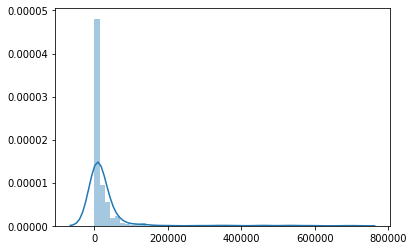

In [6]:
sns.distplot(y)

# 5. Scaling the data

In [7]:
import seaborn as sns
scaler = preprocessing.MinMaxScaler()
y = np.log(y)
y = y.reshape(-1,1)
y = scaler.fit_transform(y)
y = y.reshape(-1,)

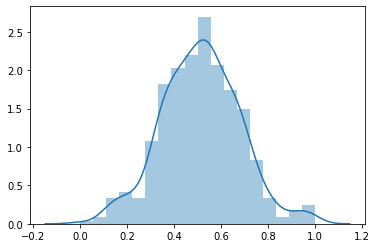

In [8]:
sns.distplot(y)

# 6. Normalizing X

In [68]:
X = X / 255.0

# 7. Splitting the data

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [70]:
print(f'Shape of X_train : {X_train.shape} | Shape of X_test : {X_test.shape} | Shape of y_train : {y_train.shape} | Shape of y_test : {y_test.shape}')

Shape of X_train : (390, 224, 224) | Shape of X_test : (44, 224, 224) | Shape of y_train : (390,) | Shape of y_test : (44,)


# Loading TensorBoard

In [10]:
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)
%load_ext tensorboard
%tensorboard --logdir {logs_base_dir}

Reusing TensorBoard on port 6006 (pid 7413), started 5:47:32 ago. (Use '!kill 7413' to kill it.)

# 8. Model Construction

In [11]:
def construct_model():
    cnn = keras.models.Sequential([
    keras.layers.Conv2D(filters=64,kernel_size=3,padding='valid',input_shape=(X.shape[1:]),data_format='channels_last',strides=(1,1),kernel_initializer='he_normal',activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2),strides=2),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=128,kernel_size=3,padding='valid',data_format='channels_last',strides=(1,1),kernel_initializer='he_normal',activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2),strides=2),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=128,kernel_size=3,padding='valid',data_format='channels_last',strides=(1,1),kernel_initializer='he_normal',activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2),strides=2),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dense(305,activation='relu',kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(17,activation='relu',kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(4,activation='relu',kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1,activation='sigmoid')])
    
    return cnn

In [12]:
model = construct_model()
adam = keras.optimizers.Adam(learning_rate=0.0001,decay=1e-6)
rmsprop = keras.optimizers.RMSprop(learning_rate=0.0001,rho=0.7,momentum=0.3)
model.compile(optimizer = adam ,loss='mse',metrics=['mse'])

lr_red = tf.keras.callbacks.ReduceLROnPlateau( 
    monitor='loss',     
    patience=4,        
    verbose=1,         
    mode="auto",       
    min_delta=0.0001,  
    cooldown=0,        
    min_lr=0.000001    
    )

In [13]:
MOD_STR = "IMG_SZ-256-4Conv[64][128][128]-KS-3-3Maxpool-KS-2-strides-2-dense--[305][17][4]-activations-[relu][relu][relu][relu]-optim[Adam]-lr[0.0001]-run--18[JUN11-2020]"

In [14]:
es = EarlyStopping(patience=30,restore_best_weights=True)
logdir = os.path.join(logs_base_dir, MOD_STR)
tb_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# 9. Model fitting

In [15]:
history = model.fit(X_train,y_train,batch_size=bs,validation_data=(X_test,y_test),epochs = 400,callbacks=[tb_callback,es,lr_red],verbose=1)

Train on 390 samples, validate on 44 samples
Epoch 1/400
390/390 [==============================] - 6s 16ms/sample - loss: 0.0875 - mse: 0.0875 - val_loss: 0.2132 - val_mse: 0.2132
Epoch 2/400
390/390 [==============================] - 3s 8ms/sample - loss: 0.0486 - mse: 0.0486 - val_loss: 0.1282 - val_mse: 0.1282
Epoch 3/400
390/390 [==============================] - 3s 8ms/sample - loss: 0.0357 - mse: 0.0357 - val_loss: 0.0508 - val_mse: 0.0508
Epoch 4/400
390/390 [==============================] - 3s 8ms/sample - loss: 0.0290 - mse: 0.0290 - val_loss: 0.0468 - val_mse: 0.0468
Epoch 5/400
390/390 [==============================] - 3s 8ms/sample - loss: 0.0257 - mse: 0.0257 - val_loss: 0.0409 - val_mse: 0.0409
Epoch 6/400
390/390 [==============================] - 3s 8ms/sample - loss: 0.0201 - mse: 0.0201 - val_loss: 0.0402 - val_mse: 0.0402
Epoch 7/400
390/390 [==============================] - 3s 8ms/sample - loss: 0.0190 - mse: 0.0190 - val_loss: 0.0433 - val_mse: 0.0433
Epoch 8/4

# Result plot

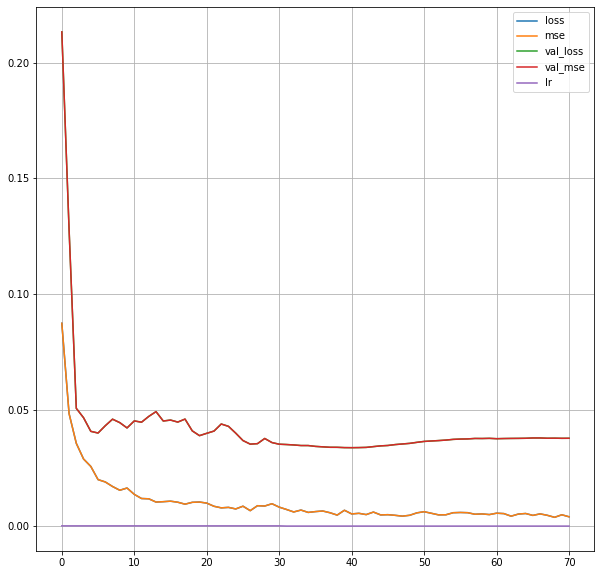

In [16]:
pd.DataFrame(history.history).plot(figsize=(10, 10))
plt.grid(True)
plt.gca().set_ylim()
plt.show()

# 10. Function to visualise prediction

In [17]:
def pred_img(inst,vis):
    predicted = X_train[inst].reshape(1,X.shape[1],X.shape[1],3)
    predicted = tf.convert_to_tensor(predicted)
    predicted = tf.cast(predicted,dtype=tf.float16)
    predicted_result = model.predict(predicted)
    predicted_result = np.array(predicted_result)
    scaled_result = scaler.inverse_transform(predicted_result)[0][0]
    scaled_result = np.exp(scaled_result)
    actual = y_train[inst]
    actual = np.reshape(actual,(-1,1))
    actual = scaler.inverse_transform(actual)[0][0]
    actual = np.exp(actual)
    error  = (abs(scaled_result - actual) / actual) * 100

    if vis:
        print(f'Prediction  = {scaled_result}')
        print(f'Actual = {actual}')
        print(f'Difference in predictions {abs(actual-scaled_result ) : .2f}')
        print(f'Error : {error : .2f} %')
        img = tf.cast(X_train[inst],dtype=tf.float32)
        plt.imshow(img)
        
    
    return error,actual,scaled_result

Prediction  = 29901.7578125
Actual = 31169.99999999999
Difference in predictions  1268.24
Error :  4.07 %


(4.068791105229354, 31169.99999999999, 29901.758)

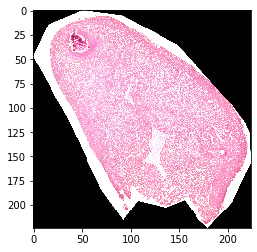

In [35]:
pred_img(9,vis=True)

In [19]:
def test_model(data):
    errs = []
    actuals = []
    predicted_ = []
    if data == 'test':
        ds = X_test
    else:
        ds = X_train
        
    for i in tqdm(range(len(ds))):
        error,actual,predicted = pred_img(i,vis=False)
        errs.append(error)
        actuals.append(actual)
        predicted_.append(predicted)
    print(f'Mean Error : {np.mean(errs)}')
    
    return errs,actuals,predicted_

In [28]:
errors,actuals,predicted = test_model('train')

100%|██████████| 390/390 [00:07<00:00, 51.45it/s]

Mean Error : 59.18019045060788


# 11 .Distribution of actuals vs predictions

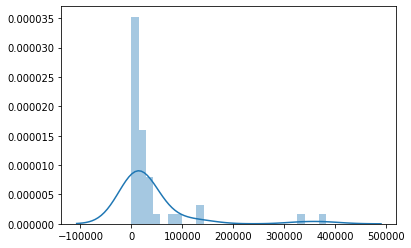

In [21]:
sns.distplot(actuals)

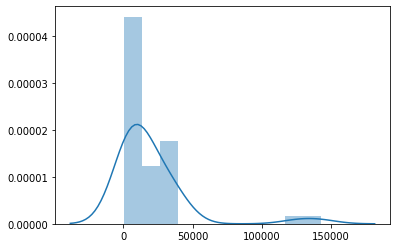

In [22]:
sns.distplot(predicted)

In [23]:
np.mean(actuals)

38634.568181818184

In [24]:
np.mean(predicted)

19699.244

In [25]:
np.max(actuals)

383071.0

In [26]:
np.max(predicted)

142296.11

# 12. Expermient with Learning Rate Finder

In [ ]:
from matplotlib import pyplot as plt
import math
from keras.callbacks import LambdaCallback
import keras.backend as K
import numpy as np


class LRFinder:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """

    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.learning_rate)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if batch > 5 and (math.isnan(loss) or loss > self.best_loss * 4):
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.learning_rate, lr)

    def find(self, x_train, y_train, start_lr, end_lr, batch_size=64, epochs=1):
        # If x_train contains data for multiple inputs, use length of the first input.
        # Assumption: the first element in the list is single input; NOT a list of inputs.
        N = x_train[0].shape[0] if isinstance(x_train, list) else x_train.shape[0]

        # Compute number of batches and LR multiplier
        num_batches = epochs * N / batch_size
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(num_batches))
        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.learning_rate)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.learning_rate, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit(x_train, y_train,
                       batch_size=batch_size, epochs=epochs,
                       callbacks=[callback])

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.learning_rate, original_lr)

    def find_generator(self, generator, start_lr, end_lr, epochs=1, steps_per_epoch=None, **kw_fit):
        if steps_per_epoch is None:
            try:
                steps_per_epoch = len(generator)
            except (ValueError, NotImplementedError) as e:
                raise e('`steps_per_epoch=None` is only valid for a'
                        ' generator based on the '
                        '`keras.utils.Sequence`'
                        ' class. Please specify `steps_per_epoch` '
                        'or use the `keras.utils.Sequence` class.')
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(epochs * steps_per_epoch))

        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.learning_rate)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.learning_rate, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch,
                                                      logs: self.on_batch_end(batch, logs))

        self.model.fit_generator(generator=generator,
                                 epochs=epochs,
                                 steps_per_epoch=steps_per_epoch,
                                 callbacks=[callback],
                                 **kw_fit)

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.learning_rate, original_lr)

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5, x_scale='log'):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], self.losses[n_skip_beginning:-n_skip_end])
        plt.xscale(x_scale)
        plt.show()

    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01)):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        derivatives = self.get_derivatives(sma)[n_skip_beginning:-n_skip_end]
        lrs = self.lrs[n_skip_beginning:-n_skip_end]
        plt.ylabel("rate of loss change")
        plt.xlabel("learning rate (log scale)")
        plt.plot(lrs, derivatives)
        plt.xscale('log')
        plt.ylim(y_lim)
        plt.show()

    def get_derivatives(self, sma):
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivatives.append((self.losses[i] - self.losses[i - sma]) / sma)
        return derivatives

    def get_best_lr(self, sma, n_skip_beginning=10, n_skip_end=5):
        derivatives = self.get_derivatives(sma)
        best_der_idx = np.argmax(derivatives[n_skip_beginning:-n_skip_end])[0]
        return self.lrs[n_skip_beginning:-n_skip_end][best_der_idx]

In [ ]:
lr_finder = LRFinder(model)

In [ ]:
lr_finder.find(X_train, y_train, start_lr=0.0001, end_lr=1, batch_size=32, epochs=10)

In [ ]:
lr_finder.plot_loss()

In [ ]:
lr_finder.plot_loss_change(sma=20, y_lim=(-0.01, 0.01))